In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000,
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


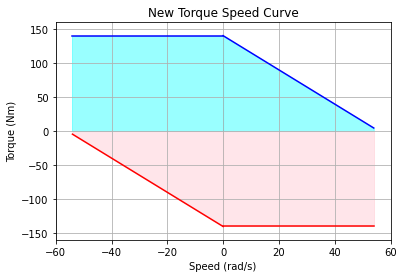

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

<a id='Select_Test'></a>

In [4]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop"}

test = tests[9]
V_avg = 8.0
mu_value = 1.0

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.2
elif test == "High_Drop_Move_Leg":
    N = 50
    TT = 0.4
elif test == "Forward_Hop":
    N = 50
    TT = 0.7
    x_final = 2.0 # for display
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 100
    TT = 0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
elif test == "Stop_Periodic_Run" or test == "Start_Periodic_Run":
    import csv
    file = open(str(round(V_avg))+'.csv')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row)
    initial_conditions = {}
    for item in rows:
        initial_conditions[item[0]] = float(item[1])
    x_final = 5.0 # for display 
    if test == "Stop_Periodic_Run":
        N = 50 #50
        TT = 3.0 # 2Hz but only half a gait due to symmetry
    elif test == "Start_Periodic_Run":
        N = 50
        TT = 1.0
    else: pass   
    
else:
    N = 50
    TT = 0.5

In [5]:
print("total mass = " ,total_mass)
print("test = ",test)

total mass =  7.75782
test =  Stop_Periodic_Run


In [6]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [7]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
# ''' CONSTRAINTS  - CONNECTION POINT'''
# m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
# m.connect_force = Var(m.N, m.signs, m.WDOFs, m.legs, bounds = (0.0,None)) # connection force

# # Lamdify
# lamb_connect_position = {} # (WDOFs,sides,leg)
# [lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# # Equate the connection equations from the previous script to the model m
# def def_connect_position_equation(m,n,wdof,side,leg):
#     var_list = get_var_list_zeros(m,n)    
#     return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
# m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# # Ensure that there is no distance between the X (and Y) of link connection points
# def def_connect_position(m,n,wdof,leg):
#     return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
# m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [10]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [11]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [12]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [13]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [14]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)       
    
    else:
        if test == "Forward_Hop":
            m.q[n,'y_body'].setub(2.0)
        else: pass
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]

<a id='initial_conditions'></a>

In [15]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    
    
    
    
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)


elif test == "Stop_Periodic_Run":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    
    m.q[1,'x_body'].fix(initial_conditions['x_body']) # initial condition
    m.q[1,'y_body'].fix(initial_conditions['y_body'])
    m.q[1,'theta_body'].fix(initial_conditions['theta_body'])
    
    m.q[1,'theta_ullA'].fix(initial_conditions['theta_ullA'])
    m.q[1,'theta_urlA'].fix(initial_conditions['theta_urlA'])
    m.q[1,'theta_ullB'].fix(initial_conditions['theta_ullB'])
    m.q[1,'theta_urlB'].fix(initial_conditions['theta_urlB'])
    
    m.q[1,'theta_lllA'].fix(initial_conditions['theta_lllA'])
    m.q[1,'theta_lrlA'].fix(initial_conditions['theta_lrlA'])
    m.q[1,'theta_lllB'].fix(initial_conditions['theta_lllB'])
    m.q[1,'theta_lrlB'].fix(initial_conditions['theta_lrlB'])
    
    m.GRF_y[1,'A'].fix(0.0)
    m.GRF_y[1,'B'].fix(0.0)
    
    m.dq[1,'x_body'].fix(initial_conditions['dx_body']) # initial condition
    m.dq[1,'y_body'].fix(initial_conditions['dy_body'])
    m.dq[1,'theta_body'].fix(initial_conditions['dtheta_body'])
    m.dq[1,'theta_ullA'].fix(initial_conditions['dtheta_ullA'])
    m.dq[1,'theta_urlA'].fix(initial_conditions['dtheta_urlA'])
    m.dq[1,'theta_ullB'].fix(initial_conditions['dtheta_ullB'])
    m.dq[1,'theta_urlB'].fix(initial_conditions['dtheta_urlB'])
    
    m.dq[1,'theta_lllA'].fix(initial_conditions['dtheta_lllA'])
    m.dq[1,'theta_lrlA'].fix(initial_conditions['dtheta_lrlA'])
    m.dq[1,'theta_lllB'].fix(initial_conditions['dtheta_lllB'])
    m.dq[1,'theta_lrlB'].fix(initial_conditions['dtheta_lrlB'])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]

    m.q[N,'x_body'].fix(initial_conditions['y_body'])
    m.q[N,'theta_body'].fix(initial_conditions['theta_body'])
    
    m.q[N,'theta_ullA'].fix(initial_conditions['theta_ullA'])
    m.q[N,'theta_urlA'].fix(initial_conditions['theta_urlA'])
    m.q[N,'theta_ullB'].fix(initial_conditions['theta_ullB'])
    m.q[N,'theta_urlB'].fix(initial_conditions['theta_urlB'])
        
    # initial condition

    m.q[N,'y_body'].fix(initial_conditions['y_body'])
    m.q[N,'theta_body'].fix(initial_conditions['theta_body'])
    
    m.q[N,'theta_ullA'].fix(initial_conditions['theta_ullA'])
    m.q[N,'theta_urlA'].fix(initial_conditions['theta_urlA'])
    m.q[N,'theta_ullB'].fix(initial_conditions['theta_ullB'])
    m.q[N,'theta_urlB'].fix(initial_conditions['theta_urlB'])
    
    m.q[N,'theta_lllA'].fix(initial_conditions['theta_lllA'])
    m.q[N,'theta_lrlA'].fix(initial_conditions['theta_lrlA'])
    m.q[N,'theta_lllB'].fix(initial_conditions['theta_lllB'])
    m.q[N,'theta_lrlB'].fix(initial_conditions['theta_lrlB'])
    
    m.dq[N,'x_body'].fix(initial_conditions['dx_body']) # initial condition
    m.dq[N,'y_body'].fix(initial_conditions['dy_body'])
    m.dq[N,'theta_body'].fix(initial_conditions['dtheta_body'])
    m.dq[N,'theta_ullA'].fix(initial_conditions['dtheta_ullA'])
    m.dq[N,'theta_urlA'].fix(initial_conditions['dtheta_urlA'])
    m.dq[N,'theta_ullB'].fix(initial_conditions['dtheta_ullB'])
    m.dq[N,'theta_urlB'].fix(initial_conditions['dtheta_urlB'])
    
    m.dq[N,'theta_lllA'].fix(initial_conditions['dtheta_lllA'])
    m.dq[N,'theta_lrlA'].fix(initial_conditions['dtheta_lrlA'])
    m.dq[N,'theta_lllB'].fix(initial_conditions['dtheta_lllB'])
    m.dq[N,'theta_lrlB'].fix(initial_conditions['dtheta_lrlB'])
    

else: pass

In [16]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [17]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [18]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [ ]:
# solving
opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    20611
Number of nonzeros in inequality constraint Jacobian.:     2050
Number of nonzeros in Lagrangian Hessian.............:     9576

Total number of variables............................:     4053
                     variables with only lower bounds:      388
                variables with lower and upper bounds:     1978
                     variables with only u

 113r 9.6790141e+06 5.19e+00 6.83e+02   0.7 2.85e+00   1.3 4.30e-01 1.45e-01f  1
 114r 9.8622596e+06 5.21e+00 5.81e+02   0.7 6.52e+00   0.9 4.61e-02 1.19e-01f  1
 115r 9.9054845e+06 5.21e+00 5.51e+02   0.7 3.98e+01   0.4 7.33e-02 6.30e-02f  1
 116r 1.0253903e+07 5.26e+00 4.57e+02   0.7 7.97e+00   0.8 1.67e-01 2.75e-01f  1
 117r 1.0246339e+07 5.25e+00 4.68e+02   0.7 9.86e+01   0.3 1.47e-02 2.38e-02f  1
 118r 1.0234102e+07 5.26e+00 3.39e+02   0.7 3.23e+01    -  1.07e-01 6.66e-02f  1
 119r 1.0493592e+07 5.28e+00 2.83e+02   0.7 2.89e+01    -  1.79e-01 1.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 1.1122322e+07 5.35e+00 4.74e+02   0.7 2.28e+01    -  1.69e-01 2.96e-01f  1
 121r 1.1764410e+07 5.42e+00 6.35e+02   0.7 8.53e+00  -0.1 7.69e-02 2.65e-01f  1
 122r 1.2252201e+07 5.50e+00 5.57e+02   0.7 1.55e+01    -  2.39e-01 2.83e-01f  1
 123r 1.2308510e+07 5.50e+00 4.08e+02   0.7 7.60e+00   0.3 9.21e-02 5.09e-02f  1
 124r 1.2431865e+07 5.52e+00

 251r 7.2049719e+06 8.13e+00 2.54e+02  -2.1 5.24e+00  -0.0 6.21e-01 2.30e-01f  1
 252r 7.2028759e+06 8.14e+00 4.56e+02  -2.1 1.35e+01  -0.5 7.90e-02 7.10e-03f  1
 253r 7.1800338e+06 8.21e+00 8.70e+02  -2.1 4.52e+00  -0.1 3.52e-01 1.44e-01f  1
 254r 7.1777790e+06 8.22e+00 8.64e+02  -2.1 1.74e+01  -0.5 4.63e-03 7.05e-03f  1
 255r 7.1713824e+06 8.22e+00 7.29e+02  -2.1 5.72e+00  -0.1 2.72e-01 3.79e-02f  1
 256r 7.1281266e+06 8.22e+00 6.07e+02  -2.1 2.05e+01  -0.6 2.86e-03 1.36e-01f  1
 257r 7.0692625e+06 8.21e+00 3.99e+02  -2.1 5.96e+00  -0.2 3.45e-01 3.67e-01f  1
 258r 7.0687589e+06 8.21e+00 3.97e+02  -2.1 1.60e+01  -0.7 3.76e-03 1.43e-03f  1
 259r 7.0674535e+06 8.21e+00 3.78e+02  -2.1 4.12e+00  -0.2 1.94e-02 8.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 7.0599661e+06 8.21e+00 3.30e+02  -2.1 2.78e+01  -0.7 7.21e-04 2.10e-02f  1
 261r 7.0575893e+06 8.21e+00 4.57e+02  -2.1 6.31e+00  -0.3 1.33e-01 1.24e-02f  1
 262r 7.0405914e+06 8.19e+00

 389r 5.6007396e+06 5.31e+00 8.54e+02  -2.1 8.80e+00  -0.8 1.00e+00 7.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 5.6046951e+06 5.31e+00 7.13e+02  -2.1 1.99e+01  -1.3 1.05e-01 1.60e-01f  1
 391r 5.6097339e+06 5.31e+00 5.86e+02  -2.1 8.06e+00  -0.9 1.00e+00 2.61e-01f  1
 392r 5.6104683e+06 5.31e+00 8.45e+02  -2.1 1.35e+01  -1.4 9.58e-01 2.20e-02f  1
 393r 5.6263117e+06 5.30e+00 5.12e+00  -2.1 6.76e+00  -0.9 1.00e+00 1.00e+00f  1
 394r 5.6333850e+06 5.29e+00 7.95e+01  -2.1 2.02e+01  -1.4 6.66e-02 1.57e-01f  1
 395r 5.6507992e+06 5.27e+00 1.72e+01  -2.1 6.62e+00  -1.0 1.00e+00 1.00e+00f  1
 396r 5.6618641e+06 5.26e+00 4.02e+00  -2.1 2.82e+00  -0.6 1.00e+00 1.00e+00f  1
 397r 5.6704452e+06 5.26e+00 1.83e+02  -2.1 1.40e+01  -1.0 4.30e-01 1.99e-01f  1
 398r 5.6706155e+06 5.26e+00 1.88e+02  -2.1 4.09e+01  -1.5 1.12e-02 1.50e-03f  1
 399r 5.6717800e+06 5.26e+00 1.36e+03  -2.1 2.88e+02    -  1.08e-01 1.44e-03f  1
iter    objective    inf_pr 

 481r 1.0781302e+07 4.68e+00 1.10e+02  -3.1 2.48e+01  -1.1 1.07e-02 1.77e-02f  1
 482r 1.1084219e+07 4.66e+00 1.08e+02  -3.1 3.99e+00  -0.7 7.88e-02 1.09e-01f  1
 483r 1.1305282e+07 4.65e+00 1.14e+02  -3.1 4.45e+01  -1.1 4.42e-03 1.30e-02f  1
 484r 1.1544624e+07 4.64e+00 9.08e+01  -3.1 4.55e+00  -0.7 1.22e-01 7.23e-02f  1
 485r 1.1686963e+07 4.63e+00 8.92e+01  -3.1 5.47e+01  -1.2 8.64e-03 7.13e-03f  1
 486r 1.1912854e+07 4.62e+00 9.93e+01  -3.1 5.10e+00  -0.8 9.51e-03 6.04e-02f  1
 487r 1.1940391e+07 4.61e+00 8.00e+01  -3.1 1.86e+00  -0.3 1.22e-01 2.20e-02f  1
 488r 1.2089081e+07 4.61e+00 8.14e+01  -3.1 6.08e+00  -0.8 2.19e-02 3.47e-02f  1
 489r 1.2259810e+07 4.59e+00 7.42e+01  -3.1 2.09e+00  -0.4 1.03e-01 1.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 1.2356818e+07 4.59e+00 5.91e+01  -3.1 7.10e+00  -0.9 6.20e-02 2.01e-02f  1
 491r 1.2513192e+07 4.58e+00 5.41e+01  -3.1 2.35e+00  -0.4 9.32e-02 9.92e-02f  1
 492r 1.2641494e+07 4.57e+00

 619r 2.2240954e+07 3.44e+00 1.80e+02  -3.1 3.55e+02    -  7.33e-03 2.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r 2.2251341e+07 3.44e+00 1.94e+02  -3.1 2.95e+02    -  8.29e-02 1.19e-02f  1
 621r 2.2265583e+07 3.44e+00 1.94e+02  -3.1 1.86e+02    -  2.61e-02 1.18e-02f  1
 622r 2.2411706e+07 3.43e+00 1.73e+02  -3.1 1.99e+02    -  6.77e-02 9.26e-02f  1
 623r 2.2474737e+07 3.43e+00 1.80e+02  -3.1 1.43e+02    -  1.08e-01 5.63e-02f  1
 624r 2.2493792e+07 3.43e+00 2.35e+02  -3.1 1.22e+02    -  1.48e-01 2.10e-02f  1
 625r 2.2496943e+07 3.43e+00 2.85e+02  -3.1 8.84e+01    -  1.89e-01 6.64e-03f  1
 626r 2.2544524e+07 3.43e+00 2.11e+02  -3.1 3.42e+01    -  1.46e-02 1.37e-01f  1
 627r 2.2575454e+07 3.42e+00 1.91e+02  -3.1 3.34e+01    -  2.49e-01 1.63e-01f  1
 628r 2.2627873e+07 3.41e+00 1.32e+02  -3.1 3.75e+01    -  2.76e-01 2.86e-01f  1
 629r 2.2589155e+07 3.41e+00 1.29e+02  -3.1 1.37e+02    -  3.78e-02 3.62e-02f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710r 2.4564093e+07 2.31e+00 5.12e+02  -7.0 9.29e+01  -1.4 1.66e-02 1.27e-02f  1
 711r 2.4604805e+07 2.29e+00 4.64e+02  -7.0 2.46e+01  -1.0 6.01e-02 3.35e-02f  1
 712r 2.4695681e+07 2.20e+00 4.66e+02  -7.0 1.17e+02  -1.5 1.50e-02 3.30e-02f  1
 713r 2.4717469e+07 2.18e+00 4.34e+02  -7.0 2.82e+01  -1.0 4.01e-02 1.67e-02f  1
 714r 2.4763094e+07 2.13e+00 4.26e+02  -7.0 1.35e+02  -1.5 2.01e-03 1.69e-02f  1
 715r 2.4797993e+07 2.11e+00 4.16e+02  -7.0 3.24e+01  -1.1 2.99e-02 2.39e-02f  1
 716r 2.4756412e+07 2.08e+00 6.70e+02  -7.0 5.44e+02  -1.6 2.07e-08 5.58e-03f  1
 717r 2.4807058e+07 2.05e+00 6.72e+02  -7.0 3.75e+01  -1.1 1.84e-02 3.22e-02f  1
 718r 2.4776943e+07 2.04e+00 5.78e+02  -7.0 3.73e+03  -1.6 5.36e-04 3.04e-04f  1
 719r 2.4777014e+07 2.04e+00 5.67e+02  -7.0 4.30e+01  -1.2 6.79e-03 4.23e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r 2.4783483e+07 2.04e+00

 845r 2.7303443e+07 5.61e-01 5.16e+02  -7.0 3.39e+00   0.1 1.25e-02 1.00e-04f  1
 846r 2.7308396e+07 5.61e-01 4.90e+02  -7.0 9.95e-01   0.5 4.52e-02 5.05e-02f  1
 847r 2.7320156e+07 5.61e-01 4.81e+02  -7.0 4.80e+00   0.1 2.51e-04 2.10e-02f  1
 848r 2.7333574e+07 5.61e-01 4.28e+02  -7.0 1.13e+00   0.5 4.73e-02 1.12e-01f  1
 849r 2.7343733e+07 5.61e-01 4.47e+02  -7.0 1.42e+01   0.0 1.44e-03 7.27e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r 2.7344820e+07 5.61e-01 4.22e+02  -7.0 1.28e+00   0.4 5.91e-02 7.22e-03f  1
 851r 2.7349044e+07 5.61e-01 3.85e+02  -7.0 4.75e-01   0.9 1.78e-01 8.74e-02f  1
 852r 2.7356055e+07 5.61e-01 3.70e+02  -7.0 1.46e+00   0.4 1.01e-02 3.87e-02f  1
 853r 2.7357302e+07 5.61e-01 3.62e+02  -7.0 5.37e-01   0.8 3.69e-02 2.20e-02f  1
 854r 2.7374737e+07 5.62e-01 3.77e+02  -7.0 1.96e+00   0.3 4.37e-03 7.87e-02f  1
 855r 2.7375521e+07 5.62e-01 3.40e+02  -7.0 6.07e-01   0.8 4.96e-02 1.20e-02f  1
 856r 2.7390526e+07 5.62e-01

In iteration 982, 1 Slack too small, adjusting variable bound
 983r 2.8058101e+07 5.84e-01 7.60e+02  -7.0 1.68e+01  -0.7 1.50e-02 9.76e-03f  1
 984r 2.8058112e+07 5.84e-01 7.60e+02  -7.0 8.02e+01  -1.2 8.01e-03 6.97e-06f  1
 985r 2.8059693e+07 5.84e-01 7.55e+02  -7.0 1.89e+01  -0.8 7.53e-05 7.07e-03f  1
 986r 2.8059701e+07 5.84e-01 7.55e+02  -7.0 1.70e+02  -1.2 1.11e-03 2.60e-06f  1
 987r 2.8059701e+07 5.84e-01 7.55e+02  -7.0 2.13e+01  -0.8 1.13e-05 1.15e-06f  1
 988r 2.8059701e+07 5.84e-01 7.55e+02  -7.0 1.91e+03  -1.3 1.58e-05 3.83e-10f  1
 989r 2.8059726e+07 5.84e-01 7.55e+02  -7.0 2.40e+01  -0.9 1.33e-02 8.17e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r 2.8057312e+07 5.85e-01 7.37e+02  -7.0 1.79e+01  -0.4 2.11e-04 2.41e-02f  1
 991r 2.8058221e+07 5.85e-01 7.35e+02  -7.0 2.70e+01  -0.9 2.56e-02 2.49e-03f  1
 992r 2.8060134e+07 5.85e-01 7.23e+02  -7.0 1.01e+01  -0.5 4.84e-02 1.70e-02f  1
 993r 2.8061040e+07 5.85e-01 7.21e+02  -7.0 3.0

1120r 2.8034185e+07 5.93e-01 5.00e+02  -7.0 1.69e+01  -1.1 1.81e-02 1.98e-02f  1
1121r 2.8034000e+07 5.93e-01 4.92e+02  -7.0 6.39e+00  -0.6 1.02e-02 2.24e-02f  1
1122r 2.8033478e+07 5.93e-01 4.89e+02  -7.0 1.90e+01  -1.1 3.90e-03 6.71e-03f  1
1123r 2.8033378e+07 5.93e-01 4.81e+02  -7.0 7.18e+00  -0.7 2.39e-02 9.32e-03f  1
1124r 2.8033312e+07 5.93e-01 4.77e+02  -7.0 2.12e+01  -1.2 1.38e-02 7.83e-04f  1
1125r 2.8033303e+07 5.93e-01 4.76e+02  -7.0 8.03e+00  -0.7 1.96e-03 1.66e-03f  1
1126r 2.8032693e+07 5.93e-01 4.69e+02  -7.0 2.39e+01  -1.2 2.31e-02 5.29e-03f  1
1127r 2.8032685e+07 5.93e-01 4.65e+02  -7.0 9.03e+00  -0.8 7.97e-03 1.83e-03f  1
1128r 2.8032465e+07 5.93e-01 4.63e+02  -7.0 2.69e+01  -1.3 7.15e-03 1.43e-03f  1
1129r 2.8031828e+07 5.92e-01 4.55e+02  -7.0 1.02e+01  -0.8 6.78e-03 9.80e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130r 2.8030308e+07 5.92e-01 4.50e+02  -7.0 3.01e+01  -1.3 1.97e-02 6.80e-03f  1
1131r 2.8030174e+07 5.92e-01

1259r 2.7881060e+07 8.28e-01 3.08e+02  -7.0 3.85e+00  -0.5 1.15e-02 2.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260r 2.7879978e+07 8.28e-01 3.06e+02  -7.0 1.07e+01  -1.0 5.46e-02 2.02e-02f  1
1261r 2.7876735e+07 8.26e-01 2.91e+02  -7.0 2.69e+01  -1.5 9.09e-03 3.00e-02f  1
1262r 2.7873562e+07 8.26e-01 2.81e+02  -7.0 1.18e+01  -1.1 7.88e-02 4.62e-02f  1
1263r 2.7872614e+07 8.23e-01 2.70e+02  -7.0 3.23e+01  -1.6 2.47e-02 3.00e-02f  1
1264r 2.7871969e+07 8.23e-01 2.71e+02  -7.0 1.30e+01  -1.1 3.45e-02 7.89e-03f  1
1265r 2.7868065e+07 8.23e-01 2.29e+02  -7.0 5.25e+00  -0.7 1.89e-02 1.28e-01f  1
1266r 2.7863926e+07 8.22e-01 2.15e+02  -7.0 1.43e+01  -1.2 1.38e-02 4.40e-02f  1
1267r 2.7861278e+07 8.22e-01 2.10e+02  -7.0 5.88e+00  -0.8 2.02e-03 2.57e-02f  1
1268r 2.7860551e+07 8.22e-01 2.06e+02  -7.0 2.25e+00  -0.3 1.46e-01 3.97e-02f  1
1269r 2.7852007e+07 8.22e-01 1.96e+02  -7.0 6.60e+00  -0.8 1.84e-02 5.72e-02f  1
iter    objective    inf_pr 

1396r 2.7640279e+07 7.81e-01 5.30e+02  -7.0 5.34e+00  -0.9 1.04e-01 6.35e-03f  1
1397r 2.7640280e+07 7.81e-01 5.29e+02  -7.0 5.93e+01  -1.4 8.20e-05 9.60e-04f  1
1398r 2.7639360e+07 7.80e-01 5.36e+02  -7.0 5.96e+00  -0.9 1.07e-01 5.30e-02f  1
1399r 2.7638590e+07 7.80e-01 3.90e+02  -7.0 2.30e+00  -0.5 4.99e-03 1.35e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400r 2.7635721e+07 7.79e-01 3.78e+02  -7.0 6.64e+00  -1.0 1.93e-01 1.27e-01f  1
1401r 2.7634786e+07 7.79e-01 2.70e+02  -7.0 2.57e+00  -0.6 3.88e-02 1.58e-01f  1
1402r 2.7634773e+07 7.79e-01 2.96e+02  -7.0 7.35e+00  -1.0 7.42e-02 8.80e-04f  1
1403r 2.7634409e+07 7.79e-01 2.70e+02  -7.0 2.87e+00  -0.6 6.74e-02 7.55e-02f  1
1404r 2.7634090e+07 7.79e-01 3.13e+02  -7.0 8.20e+00  -1.1 1.36e-01 1.71e-02f  1
1405r 2.7632320e+07 7.78e-01 3.01e+02  -7.0 2.17e+01  -1.6 8.02e-05 1.75e-02f  1
1406r 2.7629533e+07 7.77e-01 2.23e+02  -7.0 9.11e+00  -1.1 6.00e-02 1.52e-01f  1
1407r 2.7628386e+07 7.77e-01

1489r 2.7634780e+07 7.44e-01 4.39e+02  -7.0 3.73e+01  -1.9 1.05e-01 2.92e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490r 2.7639305e+07 7.43e-01 4.95e+02  -7.0 1.41e+01  -1.5 1.73e-01 6.68e-02f  1
1491r 2.7653830e+07 7.40e-01 4.73e+02  -7.0 4.24e+01  -2.0 1.01e-01 7.86e-02f  1
1492r 2.7656238e+07 7.39e-01 8.51e+02  -7.0 1.58e+01  -1.5 6.83e-01 2.92e-02f  1
1493r 2.7656278e+07 7.39e-01 8.63e+02  -7.0 4.97e+01  -2.0 4.45e-02 1.58e-04f  1
1494r 2.7656824e+07 7.39e-01 8.80e+02  -7.0 1.77e+01  -1.6 1.09e-01 5.76e-03f  1
1495r 2.7660950e+07 7.39e-01 8.69e+02  -7.0 6.36e+01  -2.1 1.36e-02 1.27e-02f  1
1496r 2.7661354e+07 7.39e-01 8.96e+02  -7.0 1.99e+01  -1.6 1.22e-01 4.87e-03f  1
1497r 2.7682218e+07 7.35e-01 8.38e+02  -7.0 1.07e+02  -2.1 1.02e-02 4.88e-02f  1
1498r 2.7696163e+07 7.33e-01 8.77e+02  -7.0 2.28e+01  -1.7 2.81e-01 9.89e-02f  1
1499r 2.7723546e+07 7.32e-01 8.65e+02  -7.0 6.30e+02  -2.2 8.88e-03 1.20e-02f  1
iter    objective    inf_pr 

1625r 2.8006346e+07 7.06e-01 4.28e+02  -7.0 2.12e+01  -1.8 1.42e-02 1.17e-02f  1
1626r 2.8011053e+07 7.05e-01 4.24e+02  -7.0 8.50e+00  -1.4 3.29e-02 2.53e-02f  1
1627r 2.8014917e+07 7.05e-01 4.21e+02  -7.0 2.30e+01  -1.8 3.86e-03 4.79e-03f  1
1628r 2.8019335e+07 7.04e-01 3.97e+02  -7.0 9.43e+00  -1.4 5.41e-03 2.11e-02f  1
1629r 2.8025416e+07 7.04e-01 3.80e+02  -7.0 3.74e+00  -1.0 8.18e-02 6.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630r 2.8031840e+07 7.03e-01 3.91e+02  -7.0 1.07e+01  -1.5 5.67e-02 3.04e-02f  1
1631r 2.8034298e+07 7.03e-01 4.20e+02  -7.0 4.26e+00  -1.0 8.52e-02 3.08e-02f  1
1632r 2.8034698e+07 7.03e-01 4.33e+02  -7.0 1.19e+01  -1.5 1.86e-02 1.67e-03f  1
1633r 2.8034790e+07 7.03e-01 4.93e+02  -7.0 4.74e+00  -1.1 8.96e-02 1.03e-03f  1
1634r 2.8036046e+07 7.03e-01 4.97e+02  -7.0 1.25e+01  -1.6 1.59e-02 5.15e-03f  1
1635r 2.8041720e+07 7.02e-01 4.45e+02  -7.0 5.05e+00  -1.1 2.63e-02 6.31e-02f  1
1636r 2.8047695e+07 7.01e-01

1762r 2.9125569e+07 6.16e-01 1.75e+02  -7.0 7.14e+00  -1.2 3.74e-02 2.61e-03f  1
1763r 2.9125636e+07 6.16e-01 1.75e+02  -7.0 2.69e+01  -1.7 1.31e-03 3.40e-04f  1
1764r 2.9127099e+07 6.16e-01 1.71e+02  -7.0 8.11e+00  -1.3 4.78e-04 1.99e-02f  1
1765r 2.9127551e+07 6.16e-01 1.71e+02  -7.0 3.25e+01  -1.7 1.05e-02 2.10e-03f  1
1766r 2.9132426e+07 6.15e-01 1.61e+02  -7.0 9.21e+00  -1.3 1.88e-02 5.85e-02f  1
1767r 2.9133384e+07 6.15e-01 1.60e+02  -7.0 3.96e+01  -1.8 1.45e-02 3.91e-03f  1
1768r 2.9138669e+07 6.15e-01 1.79e+02  -7.0 1.06e+01  -1.4 1.11e-02 6.10e-02f  1
1769r 2.9139505e+07 6.15e-01 1.81e+02  -7.0 4.49e+01  -1.9 1.67e-03 3.40e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770r 2.9148532e+07 6.14e-01 1.97e+02  -7.0 1.20e+01  -1.4 5.85e-02 8.36e-02f  1
1771r 2.9155470e+07 6.13e-01 2.06e+02  -7.0 5.42e+01  -1.9 9.04e-03 2.14e-02f  1
1772r 2.9158469e+07 6.13e-01 2.09e+02  -7.0 1.41e+01  -1.5 1.63e-02 2.28e-02f  1
1773r 2.9164454e+07 6.12e-01

1854r 2.9651781e+07 5.73e-01 1.17e+02  -7.0 4.71e+01  -1.8 1.56e-02 9.53e-02f  1
1855r 2.9653228e+07 5.73e-01 1.10e+02  -7.0 1.20e+01  -1.3 5.12e-02 5.31e-02f  1
1856r 2.9658625e+07 5.74e-01 8.30e+01  -7.0 5.53e+01  -1.8 6.00e-03 6.25e-02f  1
1857r 2.9659250e+07 5.74e-01 8.32e+01  -7.0 1.36e+01  -1.4 3.59e-02 2.60e-02f  1
1858r 2.9661993e+07 5.75e-01 7.55e+01  -7.0 6.56e+01  -1.9 3.76e-02 4.74e-02f  1
1859r 2.9662192e+07 5.76e-01 7.54e+01  -7.0 1.54e+01  -1.4 1.81e-02 1.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860r 2.9663922e+07 5.76e-01 9.62e+01  -7.0 7.85e+01  -1.9 7.25e-02 1.75e-02f  1
1861r 2.9663922e+07 5.76e-01 9.68e+01  -7.0 1.23e+02  -2.4 5.87e-03 5.30e-08h  1
1862r 2.9662825e+07 5.76e-01 9.46e+01  -7.0 2.83e+01  -2.0 7.42e-03 2.03e-02f  1
1863r 2.9658732e+07 5.77e-01 9.31e+01  -7.0 1.60e+02  -2.4 3.03e-03 7.89e-03f  1
1864r 2.9656558e+07 5.77e-01 9.08e+01  -7.0 3.21e+01  -2.0 9.30e-02 3.95e-02f  1
1865r 2.9655981e+07 5.77e-01

1991r 2.9629285e+07 6.08e-01 2.50e+02  -7.0 6.69e+00  -1.2 7.50e-02 1.80e-01f  1
1992r 2.9644701e+07 6.07e-01 2.33e+02  -7.0 2.56e+01  -1.7 8.54e-02 9.18e-02f  1
1993r 2.9655139e+07 6.07e-01 1.95e+02  -7.0 7.87e+00  -1.3 1.84e-01 1.94e-01f  1
1994r 2.9660960e+07 6.07e-01 1.25e+02  -7.0 4.73e+01  -1.7 1.08e-01 1.72e-02f  1
1995r 2.9674132e+07 6.07e-01 1.68e+02  -7.0 9.07e+00  -1.3 3.53e-02 1.48e-01f  1
1996r 2.9679503e+07 6.07e-01 1.67e+02  -7.0 1.12e+02  -1.8 5.71e-03 4.70e-03f  1
1997r 2.9684231e+07 6.07e-01 1.09e+02  -7.0 1.06e+01  -1.4 1.36e-01 4.06e-02f  1
1998r 2.9686548e+07 6.07e-01 1.06e+02  -7.0 7.22e+02  -1.8 1.27e-03 2.92e-04f  1
1999r 2.9697899e+07 6.07e-01 1.34e+02  -7.0 1.28e+01  -1.4 1.31e-03 7.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000r 2.9700919e+07 6.07e-01 1.36e+02  -7.0 4.41e+00  -1.0 4.01e-02 6.64e-02f  1
2001r 2.9701930e+07 6.07e-01 1.36e+02  -7.0 1.67e+01  -1.5 6.11e-03 5.13e-03f  1
2002r 2.9703467e+07 6.07e-01

2084r 2.9891838e+07 6.29e-01 3.49e+02  -7.0 4.70e+01  -2.2 1.45e-03 5.48e-04f  1
2085r 2.9890531e+07 6.28e-01 3.39e+02  -7.0 1.76e+01  -1.8 1.68e-01 2.95e-02f  1
2086r 2.9877804e+07 6.28e-01 3.35e+02  -7.0 5.01e+01  -2.3 3.23e-03 1.12e-02f  1
2087r 2.9878076e+07 6.28e-01 3.34e+02  -7.0 1.91e+01  -1.9 7.39e-02 4.14e-03f  1
2088r 2.9887611e+07 6.28e-01 2.64e+02  -7.0 7.28e+00  -1.4 3.80e-02 2.08e-01f  1
2089r 2.9896288e+07 6.27e-01 2.54e+02  -7.0 2.23e+01  -1.9 3.90e-02 4.03e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2090r 2.9912459e+07 6.27e-01 2.46e+02  -7.0 6.75e+01  -2.4 3.54e-03 3.04e-02f  1
2091r 2.9914336e+07 6.27e-01 2.44e+02  -7.0 2.50e+01  -2.0 9.97e-02 7.46e-03f  1
2092r 2.9926745e+07 6.26e-01 2.39e+02  -7.0 7.78e+01  -2.4 2.91e-02 2.08e-02f  1
2093r 2.9933499e+07 6.26e-01 2.33e+02  -7.0 2.82e+01  -2.0 1.89e-02 2.42e-02f  1
2094r 2.9936669e+07 6.26e-01 2.31e+02  -7.0 9.06e+01  -2.5 2.09e-02 1.03e-02f  1
2095r 2.9943404e+07 6.26e-01

2221r 3.1053672e+07 4.99e-01 6.20e+01  -7.0 1.02e+01  -1.7 8.20e-06 7.39e-02f  1
2222r 3.1055429e+07 4.99e-01 5.83e+01  -7.0 3.71e+00  -1.2 6.00e-02 6.98e-02f  1
2223r 3.1060980e+07 4.95e-01 5.86e+01  -7.0 1.16e+01  -1.7 4.89e-06 1.25e-01f  1
2224r 3.1064581e+07 4.94e-01 5.35e+01  -7.0 4.21e+00  -1.3 8.21e-02 1.21e-01f  1
2225r 3.1072313e+07 4.92e-01 4.89e+01  -7.0 1.58e+00  -0.9 2.03e-01 4.79e-01f  1
2226r 3.1076825e+07 4.88e-01 4.31e+01  -7.0 5.21e+00  -1.3 4.34e-03 9.93e-02f  1
2227r 3.1086818e+07 4.84e-01 3.17e+01  -7.0 1.85e+00  -0.9 8.51e-02 5.15e-01f  1
2228r 3.1087214e+07 4.84e-01 6.10e+01  -7.0 5.06e+00  -1.4 6.07e-02 6.26e-03f  1
2229r 3.1088165e+07 4.84e-01 4.91e+01  -7.0 1.94e+00  -1.0 6.53e-02 7.47e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230r 3.1092169e+07 4.83e-01 2.80e+01  -7.0 5.90e+00  -1.4 1.28e-02 9.27e-02f  1
2231r 3.1098552e+07 4.82e-01 2.87e+02  -7.0 2.19e+00  -1.0 2.87e-02 3.98e-01f  1
2232r 3.1107851e+07 4.79e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360r 3.2039339e+07 4.46e-01 2.73e+02  -7.0 2.72e+01  -2.1 5.51e-03 1.24e-02f  1
2361r 3.2042231e+07 4.46e-01 2.77e+02  -7.0 1.62e+02  -2.5 7.20e-03 2.34e-03f  1
2362r 3.2051195e+07 4.46e-01 2.72e+02  -7.0 3.18e+01  -2.1 3.84e-03 1.51e-02f  1
2363r 3.2053907e+07 4.45e-01 2.75e+02  -7.0 2.63e+02  -2.6 4.77e-03 1.12e-03f  1
2364r 3.2066742e+07 4.45e-01 2.73e+02  -7.0 4.25e+01  -2.2 2.11e-02 1.08e-02f  1
2365r 3.2082656e+07 4.45e-01 2.63e+02  -7.0 1.12e+01  -1.7 2.73e-03 3.73e-02f  1
2366r 3.2088491e+07 4.45e-01 2.64e+02  -7.0 5.29e+01  -2.2 1.65e-02 4.05e-03f  1
2367r 3.2101121e+07 4.44e-01 2.57e+02  -7.0 1.30e+01  -1.8 1.19e-02 2.52e-02f  1
2368r 3.2104081e+07 4.44e-01 2.59e+02  -7.0 6.81e+01  -2.3 1.13e-02 1.64e-03f  1
2369r 3.2105103e+07 4.44e-01 2.40e+02  -7.0 1.51e+01  -1.8 9.13e-02 1.62e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370r 3.2114214e+07 4.44e-01

2498r 3.3012448e+07 3.60e-01 5.52e+02  -7.0 2.15e+01  -2.0 2.58e-02 2.68e-02f  1
2499r 3.3000218e+07 3.60e-01 5.56e+02  -7.0 2.89e+02  -2.5 1.81e-03 2.25e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500r 3.2969624e+07 3.58e-01 6.13e+02  -7.0 2.50e+01  -2.0 1.54e-02 5.81e-02f  1
2501r 3.2969271e+07 3.58e-01 6.02e+02  -7.0 4.73e+02  -2.5 6.46e-04 4.34e-05f  1
2502r 3.2958759e+07 3.58e-01 5.96e+02  -7.0 3.61e+01  -2.1 7.96e-03 1.98e-02f  1
2503r 3.2932192e+07 3.56e-01 5.23e+02  -7.0 9.75e+00  -1.7 3.14e-02 2.17e-01f  1
2504r 3.2928722e+07 3.56e-01 4.93e+02  -7.0 3.21e+00  -1.2 2.68e-02 8.18e-02f  1
2505r 3.2910768e+07 3.54e-01 5.56e+02  -7.0 1.05e+01  -1.7 1.53e-02 1.30e-01f  1
2506r 3.2910610e+07 3.54e-01 4.87e+02  -7.0 4.02e+00  -1.3 1.07e-01 1.02e-02h  1
2507r 3.2910259e+07 3.54e-01 4.78e+02  -7.0 1.35e+01  -1.8 3.09e-03 1.49e-02f  1
2508r 3.2905635e+07 3.52e-01 5.03e+02  -7.0 4.55e+00  -1.3 4.82e-02 2.55e-01f  1
2509r 3.2905344e+07 3.52e-01

In [ ]:
print(results.solver.termination_condition) # check if optimal

In [ ]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

In [ ]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 

In [ ]:
N

In [ ]:
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
if test == 'Periodic_Run':
    csv_file_name = str(int(V_avg))
    
    heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
    data1 = [xbody[0],ybody[0],thbody[0],thullA[0],thurlA[0],thlllA[0],thlrlA[0],thullB[0],thurlB[0],thlllB[0],thlrlB[0]]
    heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
    data2 = [dxbody[0],dybody[0],dthbody[0],dthullA[0],dthurlA[0],dthlllA[0],dthlrlA[0],dthullB[0],dthurlB[0],dthlllB[0],dthlrlB[0]]
    heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
    data3 = [ddxbody[0],ddybody[0],ddthbody[0],ddthullA[0],ddthurlA[0],ddthlllA[0],ddthlrlA[0],ddthullB[0],ddthurlB[0],ddthlllB[0],ddthlrlB[0]]
    
    heading = heading1 + heading2 + heading3
    data = data1 + data2 + data3
    
    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)
        
        for item in range(len(heading)):
            tmp = [heading[item],data[item]]
            writer.writerow(tmp)

plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

In [ ]:
m.connect_force[50,'Y','B'].value

In [ ]:
m.dq[47,'theta_body'].value

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>